In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler


In [2]:
# Path to CSV file
file_path = 'Mushrooms.data.csv'

# Column names of dataset 
column_names = [
    'poisonous', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Load the dataset
df = pd.read_csv(file_path, sep=',', names=column_names, header=None)

# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head()

# Check if there are any missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Save the dataframe for the next steps
df.to_csv('explored_mushrooms.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8125 entries, 0 to 8124
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8125 non-null   object
 1   cap-shape                 8125 non-null   object
 2   cap-surface               8125 non-null   object
 3   cap-color                 8125 non-null   object
 4   bruises                   8125 non-null   object
 5   odor                      8125 non-null   object
 6   gill-attachment           8125 non-null   object
 7   gill-spacing              8125 non-null   object
 8   gill-size                 8125 non-null   object
 9   gill-color                8125 non-null   object
 10  stalk-shape               8125 non-null   object
 11  stalk-root                8125 non-null   object
 12  stalk-surface-above-ring  8125 non-null   object
 13  stalk-surface-below-ring  8125 non-null   object
 14  stalk-color-above-ring  

In [3]:
# Load the dataset
df = pd.read_csv('explored_mushrooms.csv')

# Clean and preprocess the data
df['poisonous'] = df['poisonous'].replace({'poisonous': 'p', 'edible': 'e'})
df['poisonous'] = df['poisonous'].map({'p': 1, 'e': 0})

# Handle missing values by filling with mode
df = df.apply(lambda col: col.fillna(col.mode()[0]))

# Save the cleaned dataframe
df.to_csv('cleaned_mushrooms.csv', index=False)


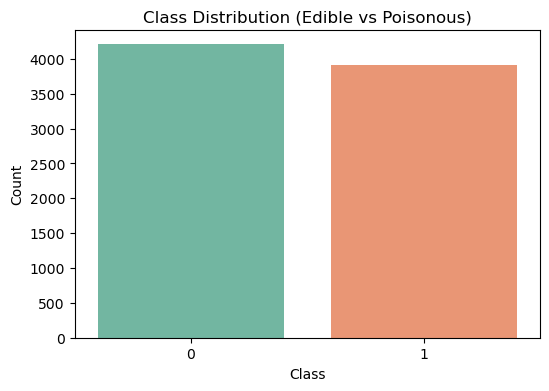

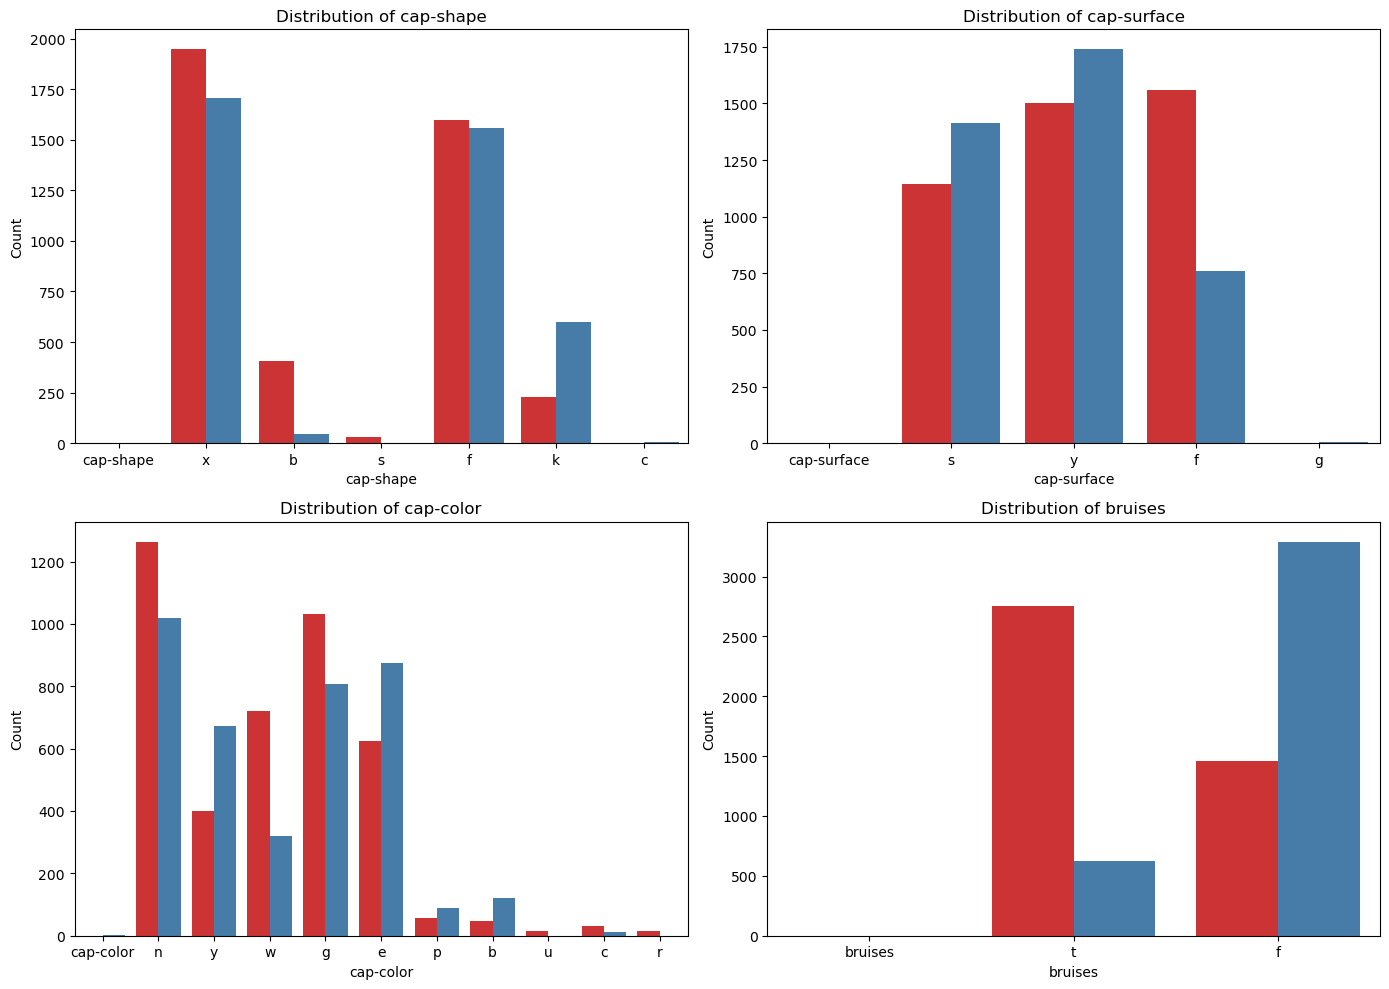

In [ ]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_mushrooms.csv')

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='poisonous', data=df, hue='poisonous', palette="Set2", legend=False)
plt.title('Class Distribution (Edible vs Poisonous)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot the distribution of the first few categorical features
plt.figure(figsize=(14, 10))
for i, column in enumerate(df.columns[1:5]):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=column, data=df, hue='poisonous', palette="Set1", legend=False)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()



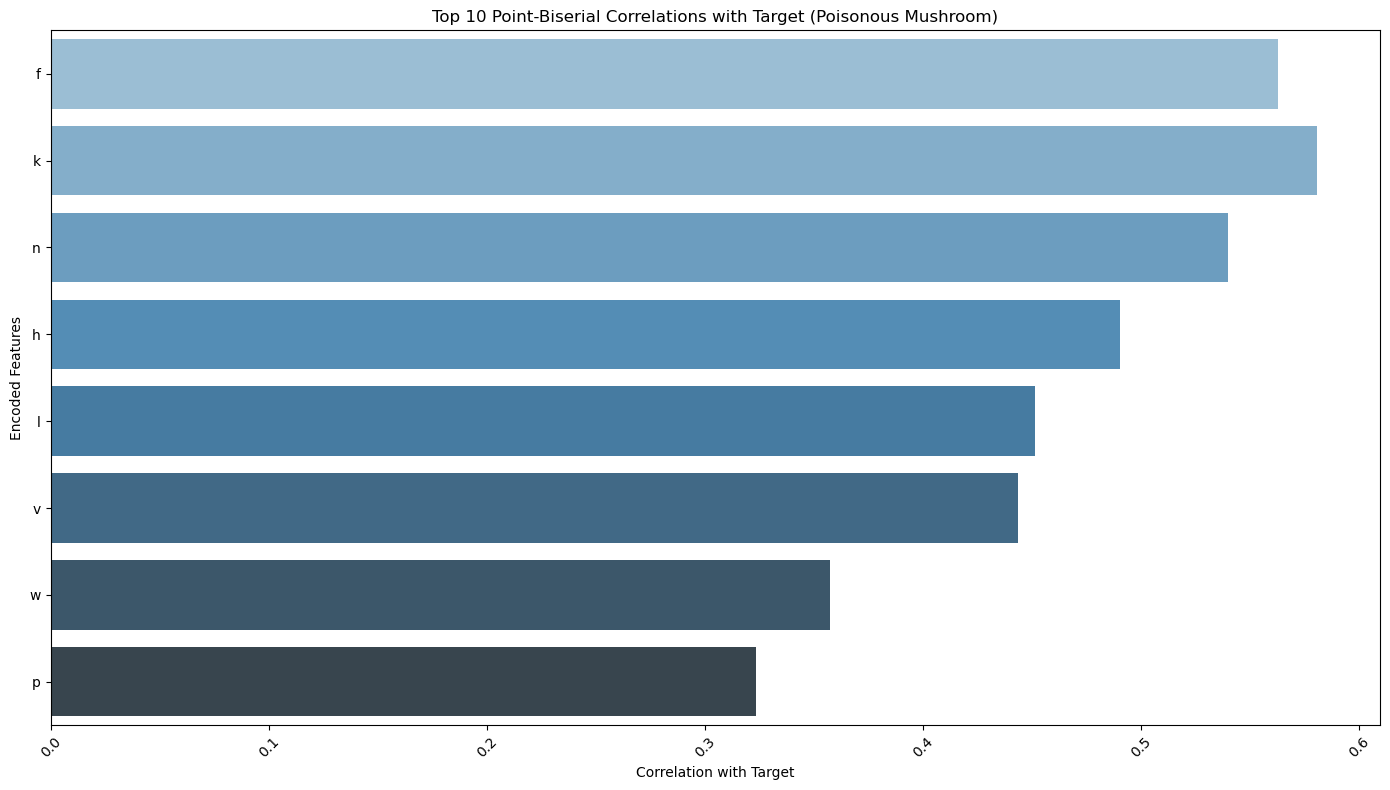

In [5]:
# Load cleaned data
df = pd.read_csv('cleaned_mushrooms.csv')

# Calculate point-biserial correlation for each feature
correlations = []
for column in df.columns[1:]:  
    feature = pd.get_dummies(df[column], drop_first=True) 
    for col in feature.columns:
        corr, _ = pointbiserialr(df['poisonous'], feature[col])
        correlations.append((column, col, corr))

corr_df = pd.DataFrame(correlations, columns=['Feature', 'Encoded Feature', 'Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Save top correlated features
top_corr_df = corr_df.head(10)
top_corr_df.to_csv('top_correlated_features.csv', index=False)

# Plot top correlated features
plt.figure(figsize=(14, 8)) 
sns.barplot(x='Correlation', y='Encoded Feature', data=top_corr_df, hue='Encoded Feature', palette='Blues_d', dodge=False, errorbar=None, legend=False)
plt.title('Top 10 Point-Biserial Correlations with Target (Poisonous Mushroom)')
plt.xlabel('Correlation with Target')
plt.ylabel('Encoded Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Load cleaned data
df = pd.read_csv('cleaned_mushrooms.csv')

# Convert categorical features to one-hot encoded variables
y = df['poisonous']
X = pd.get_dummies(df.drop('poisonous', axis=1), drop_first=True)

# Convert any boolean columns to integers
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Verify the encoding
print(X.dtypes)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Continue with feature selection and splitting the dataset
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_resampled, y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

# Save train/test data
pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)


cap-shape_c            int32
cap-shape_cap-shape    int32
cap-shape_f            int32
cap-shape_k            int32
cap-shape_s            int32
                       ...  
habitat_l              int32
habitat_m              int32
habitat_p              int32
habitat_u              int32
habitat_w              int32
Length: 117, dtype: object


In [ ]:
# Load train/test data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the SVM model
svm_model = SVC(kernel='linear', C=0.1, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {np.mean(cv_scores)}")

# Fit the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Cross-validation scores: [0.97550111 0.97253155 0.98142645 0.97994056 0.97399703]
Average cross-validation score: 0.976679341357328
Confusion Matrix:
[[823  20]
 [ 14 827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       843
           1       0.98      0.98      0.98       841

    accuracy                           0.98      1684
   macro avg       0.98      0.98      0.98      1684
weighted avg       0.98      0.98      0.98      1684


Accuracy Score:
0.9798099762470309
